In [1]:
import time
import sys
from os import walk
import os.path as ospa
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy.signal import butter, lfilter
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

# %matplotlib notebook 
# %matplotlib notebook 
# plt.rcParams["figure.figsize"] = (9,4)
# plt.rcParams.update({'font.size': 12})

plt.rcParams["figure.figsize"] = (17,6)
plt.rcParams.update({'font.size': 20})

figTitleSize = 28

sensorRange = 1023

# Capacitance Sensor Data
dataPath = ".\ForceTest0729"

for root, directories, files in walk(dataPath):
    for fileName in files:
        print(fileName)

# Force Sensor Data
xlsData = pd.ExcelFile('Sensor test 21_07_29_2.xls')

Data_Fs11Hz_at17-46-02_Official36Sensor_t23.csv
Data_Fs12Hz_at17-58-40_Official36Sensor_t25.csv
Data_Fs13Hz_at18-09-13_Official1Sensor_t27.csv
Data_Fs15Hz_at15-25-20_OfficialTest_t09.csv
Data_Fs15Hz_at17-40-21_Official36Sensor_t22.csv
Data_Fs16Hz_at17-36-52_Official36Sensor_t21.csv
Data_Fs17Hz_at15-32-41_OfficialTest_t10.csv
Data_Fs17Hz_at15-35-32_OfficialTest_t11.csv
Data_Fs17Hz_at15-39-11_OfficialTest_t12.csv
Data_Fs18Hz_at16-28-29_OfficialTest_t17.csv
Data_Fs18Hz_at16-31-05_OfficialTest_t18.csv
Data_Fs19Hz_at15-59-18_OfficialTest_t14.csv
Data_Fs19Hz_at16-40-23_OfficialTest_t19.csv
Data_Fs19Hz_at16-44-46_OfficialTest_t20.csv
Data_Fs19Hz_at18-03-29_Official1Sensor_t26.csv
Data_Fs20Hz_at14-45-05_OfficialTest_t01.csv
Data_Fs20Hz_at14-48-59_OfficialTest_t02.csv
Data_Fs20Hz_at14-52-41_OfficialTest_t03.csv
Data_Fs20Hz_at14-56-20_OfficialTest_t04.csv
Data_Fs20Hz_at14-59-51_OfficialTest_t05.csv
Data_Fs20Hz_at15-07-29_OfficialTestRedChan_t05.csv
Data_Fs20Hz_at15-42-22_OfficialTest_t13.csv


In [2]:
def movingAvgFilter(data_in, filt_size):
    # How to use: cAvg = movingAvgFilter(capa[:,0], 40)
    half_size = int(filt_size/2)
    data_out = np.convolve(data_in, np.ones(filt_size)/filt_size, mode='same')
    data_out[:half_size] = data_out[half_size]
    data_out[-half_size:] = data_out[-half_size]
    return data_out

def normRange(data_in):
    dMax = np.max(data_in)
    dMin = np.min(data_in)
    data_out = (data_in - dMin)/(dMax - dMin) # Range: 0 to 1
    data_out = (data_out - 0.5) * 2 # Range: -1 to 1
    return data_out

def sychronize(data1, t1, data2, t2, manualShift = 0.0, smoothRes = 0.002, isPlot = True):
    smoothNum = int(t1[-1]/smoothRes)
#     print(smoothNum)
    tS = np.linspace(0, t1[-1], num = smoothNum, endpoint=True) # Spline fitting to adjust time frames
    
    splineFit = interpolate.splrep(t1, data1)
    data1Smooth = interpolate.splev(tS, splineFit)

    if(t2.iloc[-1] > tS[-1]):
        sys.exit("Second input data must have a shorter measurement time!")
    
    tS2 = tS[tS <= t2.iloc[-1]]
    splineFit2 = interpolate.splrep(t2, data2)
    data2Smooth = interpolate.splev(tS2, splineFit2)

    data1UltraSmooth = movingAvgFilter(data1Smooth, 40)
    cNorm = normRange(data1UltraSmooth)
    dNorm = normRange(data2Smooth) # Flip displacement measurement
    correl = np.correlate(cNorm, dNorm, "full")
    maxInd = np.argmax(correl)
    
    if(maxInd < tS.shape[0]):
        manualShift += (tS[maxInd] - tS2[-1])
        print("Automatically Shifted %.3f sec" % (manualShift))
    
    tS2 += manualShift

    if(isPlot):
        fig1, ax1 = plt.subplots()
        ax1.set_xlabel('Time (sec)')

#         ax1.plot(tS, data1Smooth, color='tab:red') # Directly show Hex Reading
#         ax1.set_ylabel('C. Hex to Dec', color='tab:red') # Directly show Hex Reading
        ax1.plot(tS, data1Smooth/sensorRange * 100, color='tab:red')
        ax1.set_ylabel('Capac. Measure. Range (%)', color='tab:red')
        ax1.tick_params(axis='y', labelcolor='tab:red')

        ax2 = ax1.twinx() 
        ax2.plot(tS2, data2Smooth, color='tab:blue')
        ax2.set_ylabel('Displacement (mm)', color='tab:blue')
        ax2.tick_params(axis='y', labelcolor='tab:blue')

        fig1.tight_layout() 
        
    return data1Smooth, tS, data2Smooth, tS2, manualShift

def plotForceDispl(dataForce, dataDispl, t, tShift):
    fig1, ax1 = plt.subplots()
    ax1.set_xlabel('Time (sec)')

    ax1.plot(t+tShift, dataForce, color='tab:brown')
    ax1.set_ylabel('Force (N)', color='tab:brown')
    ax1.tick_params(axis='y', labelcolor='tab:brown')

    ax2 = ax1.twinx() 
    ax2.plot(t+tShift, -dataDispl, color='tab:blue')
    ax2.set_ylabel('Displacement (mm)', color='tab:blue')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig1.tight_layout() 


def computeSNR(data_in, t1, timeFlag, fs = 20):
    tRange = timeFlag[1] - timeFlag[0]
    tStart = timeFlag[0] + tRange * 0.2
    tEnd = timeFlag[1] - tRange * 0.2
    activeInd = (t1 > tStart) & (t1 <= tEnd)
    sigMean = np.mean(data_in[activeInd])
    x = data_in - sigMean

    cutoff = 5
    bL, aL = butter(10, cutoff * 2/ fs, btype='low', analog=False)
    bH, aH = butter(10, cutoff * 2/ fs, btype='high', analog=False)
    xSignal = lfilter(bL, aL, x)
    xNoise = lfilter(bH, aH, x)
    
    xValidRange = np.max(xSignal[activeInd]) - np.min(xSignal[activeInd])
    print("Measured signals span %.3f%% of board measurement range" % ((xValidRange)/sensorRange * 100))
    
#     plt.subplots() # Debug use
#     plt.plot(x, 'k') # Debug use
#     plt.plot(xSignal[activeInd], 'r') # Debug use
#     plt.plot(xNoise[activeInd], 'b') # Debug use
    S = np.mean(xSignal[activeInd]**2)
    N = np.mean(xNoise[activeInd]**2)
    return (10*np.log10(S/N))

Automatically Shifted 10.093 sec
Measured signals span 13.805% of board measurement range
Measurement 5 SNR = 17.87 dB



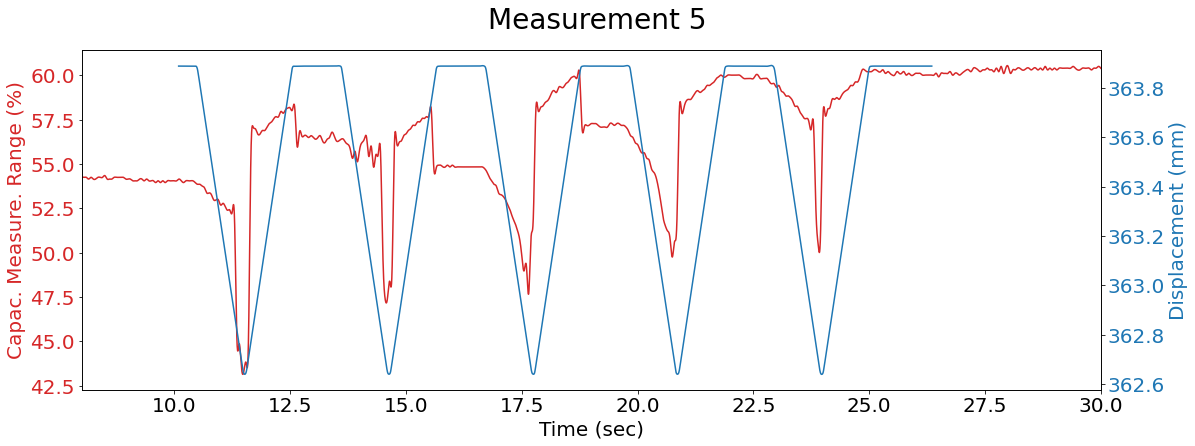

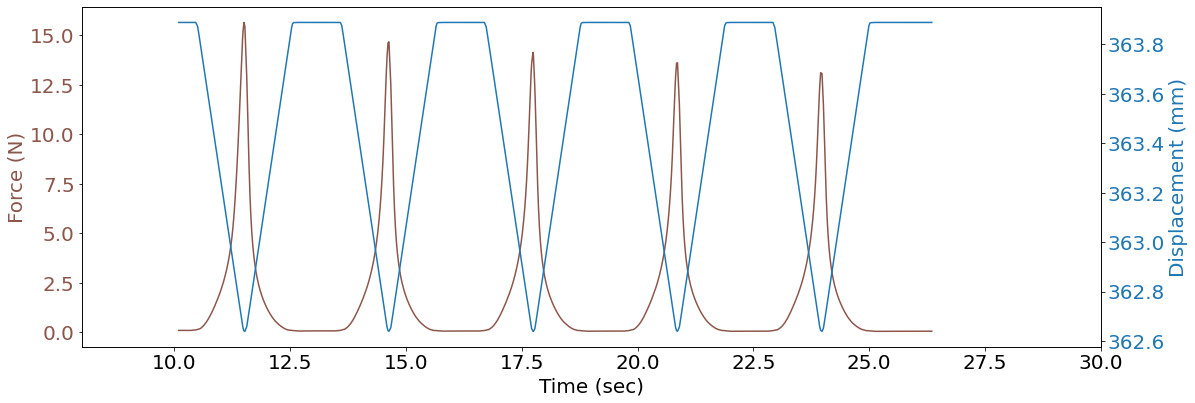

In [3]:
capa = np.genfromtxt(ospa.join(dataPath, 'Data_Fs20Hz_at14-59-51_OfficialTest_t05.csv'), delimiter=',')
t1 = np.arange(capa.shape[0])/20

timeFlag = [8, 30] # Begin and end time of displayed measurement

measurementNum = 5
keyStr0 = ("Measurement %d" % measurementNum)
keyStr1 = ("Measurement %d.1" % measurementNum)
keyStr2 = ("Measurement %d.2" % measurementNum)

fo = pd.read_excel(xlsData, keyStr0)
t2 = fo.loc[2:,keyStr0]
Force = fo.loc[2:,keyStr1]
Disp = fo.loc[2:,keyStr2]
    
cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,1], t1, -Disp, t2, manualShift = -9.15)
plt.gcf().suptitle(keyStr0, fontsize=figTitleSize, y=1.05)
plt.gca().set_xlim(timeFlag);

plotForceDispl(Force, Disp, t2, tShift)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,1], t1, timeFlag)
print("Measurement %d SNR = %.2f dB\n" % (measurementNum, signalSNR))

Automatically Shifted 8.650 sec
Measured signals span 5.824% of board measurement range
Measurement 6 SNR = 31.94 dB



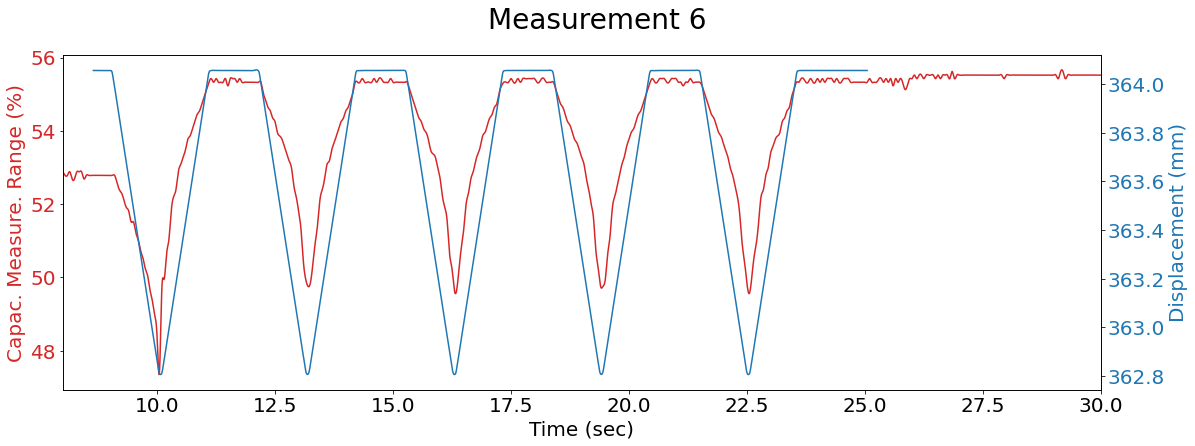

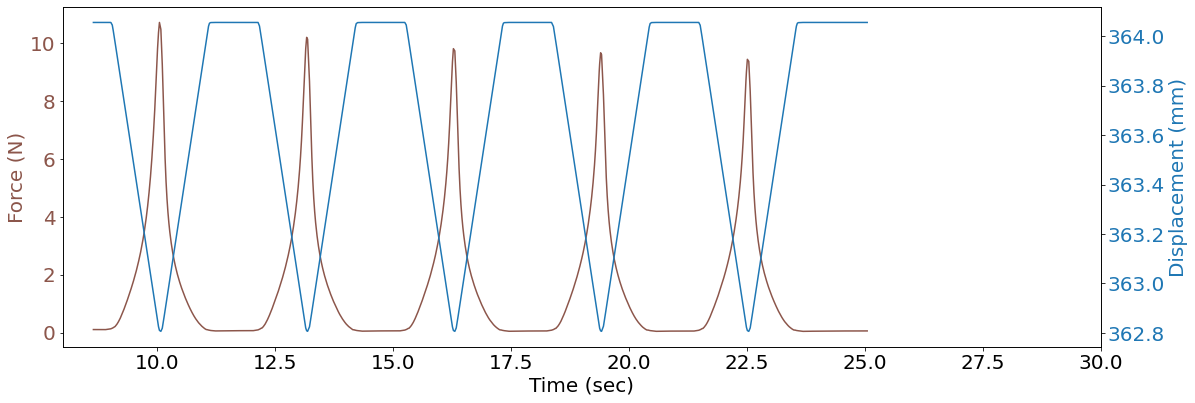

In [4]:
capa = np.genfromtxt(ospa.join(dataPath, 'Data_Fs20Hz_at15-07-29_OfficialTestRedChan_t05.csv'), delimiter=',')
t1 = np.arange(capa.shape[0])/20

timeFlag = [8, 30] # Begin and end time of displayed measurement

measurementNum = 6
keyStr0 = ("Measurement %d" % measurementNum)
keyStr1 = ("Measurement %d.1" % measurementNum)
keyStr2 = ("Measurement %d.2" % measurementNum)

fo = pd.read_excel(xlsData, keyStr0)
t2 = fo.loc[2:,keyStr0]
Force = fo.loc[2:,keyStr1]
Disp = fo.loc[2:,keyStr2]
    
cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,0], t1, -Disp, t2)
plt.gcf().suptitle(keyStr0, fontsize=figTitleSize, y=1.05)
plt.gca().set_xlim(timeFlag);

plotForceDispl(Force, Disp, t2, tShift)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,0], t1, timeFlag)
print("Measurement %d SNR = %.2f dB\n" % (measurementNum, signalSNR))

Automatically Shifted 9.708 sec
Measured signals span 6.192% of board measurement range
Measurement 9 SNR = 23.56 dB



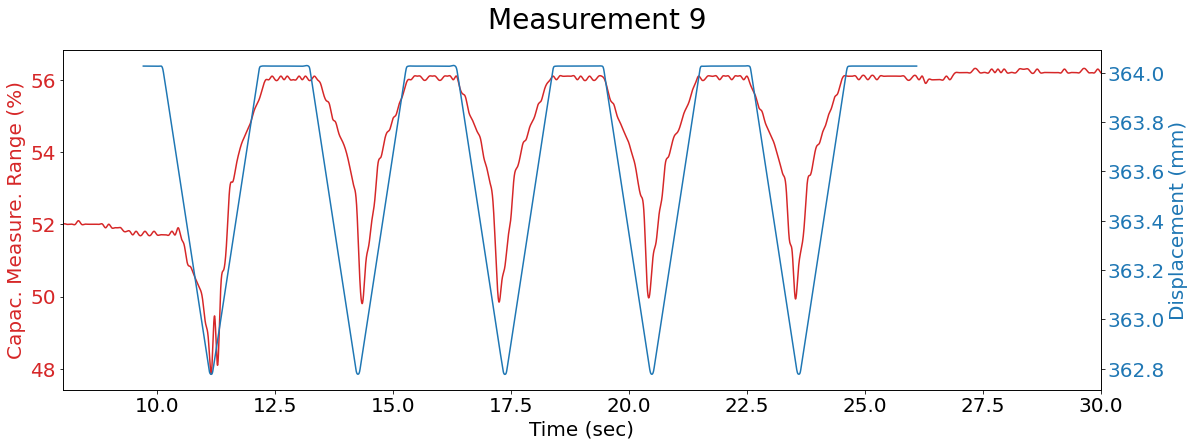

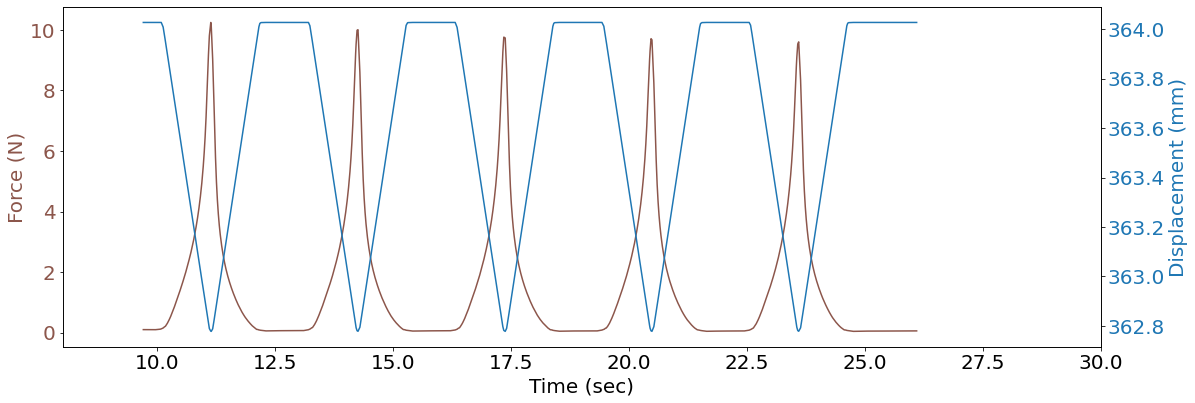

In [5]:
capa = np.genfromtxt(ospa.join(dataPath, 'Data_Fs15Hz_at15-25-20_OfficialTest_t09.csv'), delimiter=',')
t1 = np.arange(capa.shape[0])/15.6

timeFlag = [8, 30] # Begin and end time of displayed measurement

measurementNum = 9
keyStr0 = ("Measurement %d" % measurementNum)
keyStr1 = ("Measurement %d.1" % measurementNum)
keyStr2 = ("Measurement %d.2" % measurementNum)

fo = pd.read_excel(xlsData, keyStr0)
t2 = fo.loc[2:,keyStr0]
Force = fo.loc[2:,keyStr1]
Disp = fo.loc[2:,keyStr2]
    
cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,0], t1, -Disp, t2)
plt.gcf().suptitle(keyStr0, fontsize=figTitleSize, y=1.05)
plt.gca().set_xlim(timeFlag);

plotForceDispl(Force, Disp, t2, tShift)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,0], t1, timeFlag)
print("Measurement %d SNR = %.2f dB\n" % (measurementNum, signalSNR))

Automatically Shifted 8.872 sec
Measured signals span 6.383% of board measurement range
Measurement 10 SNR = 25.96 dB



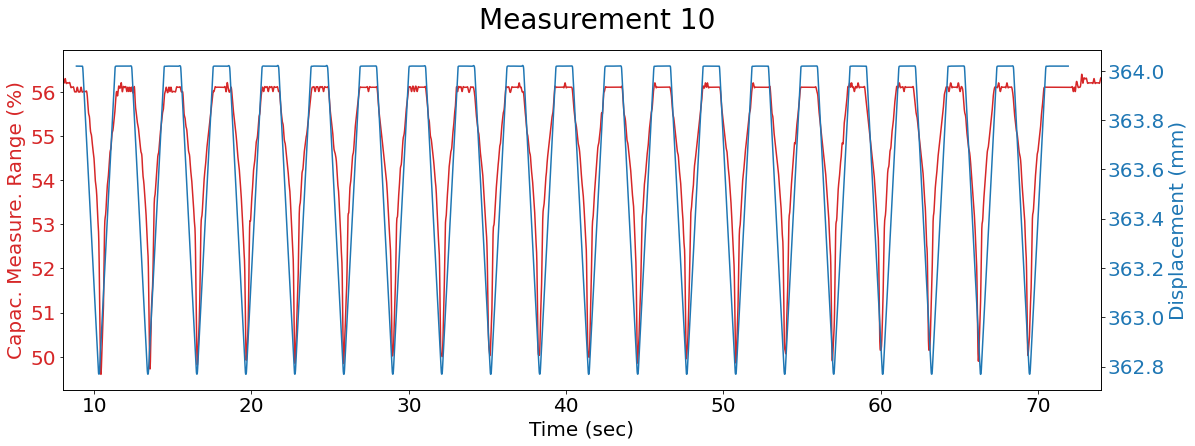

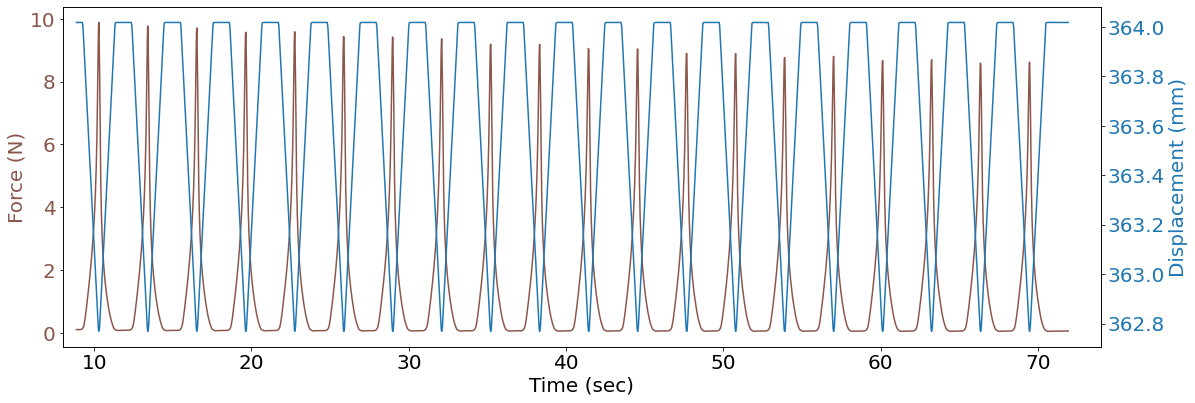

In [6]:
capa = np.genfromtxt(ospa.join(dataPath, 'Data_Fs17Hz_at15-32-41_OfficialTest_t10.csv'), delimiter=',')
t1 = np.arange(capa.shape[0])/16.8

timeFlag = [8, 74] # Begin and end time of displayed measurement

measurementNum = 10
keyStr0 = ("Measurement %d" % measurementNum)
keyStr1 = ("Measurement %d.1" % measurementNum)
keyStr2 = ("Measurement %d.2" % measurementNum)

fo = pd.read_excel(xlsData, keyStr0)
t2 = fo.loc[2:,keyStr0]
Force = fo.loc[2:,keyStr1]
Disp = fo.loc[2:,keyStr2]
    
cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,0], t1, -Disp, t2)
plt.gcf().suptitle(keyStr0, fontsize=figTitleSize, y=1.05)
plt.gca().set_xlim(timeFlag);

plotForceDispl(Force, Disp, t2, tShift)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,0], t1, timeFlag)
print("Measurement %d SNR = %.2f dB\n" % (measurementNum, signalSNR))

Automatically Shifted 9.462 sec
Measured signals span 6.248% of board measurement range
Measurement 11 SNR = 25.74 dB



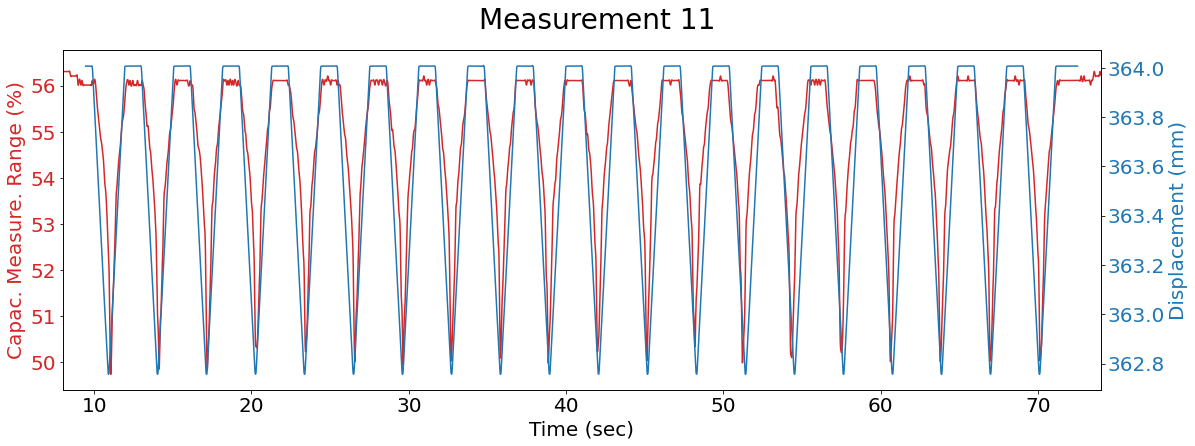

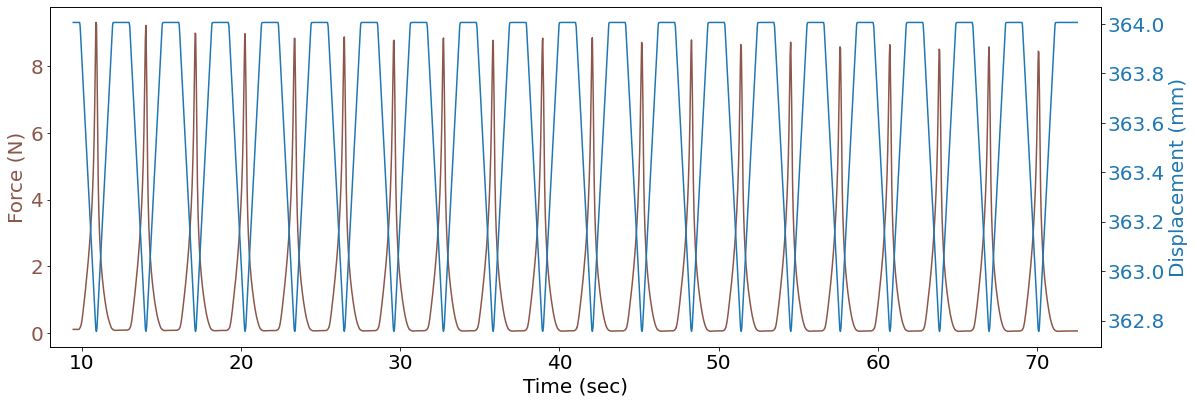

In [7]:
capa = np.genfromtxt(ospa.join(dataPath, 'Data_Fs17Hz_at15-35-32_OfficialTest_t11.csv'), delimiter=',')
t1 = np.arange(capa.shape[0])/16.7

timeFlag = [8, 74] # Begin and end time of displayed measurement

measurementNum = 11
keyStr0 = ("Measurement %d" % measurementNum)
keyStr1 = ("Measurement %d.1" % measurementNum)
keyStr2 = ("Measurement %d.2" % measurementNum)

fo = pd.read_excel(xlsData, keyStr0)
t2 = fo.loc[2:,keyStr0]
Force = fo.loc[2:,keyStr1]
Disp = fo.loc[2:,keyStr2]
    
cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,0], t1, -Disp, t2)
plt.gcf().suptitle(keyStr0, fontsize=figTitleSize, y=1.05)
plt.gca().set_xlim(timeFlag);

plotForceDispl(Force, Disp, t2, tShift)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,0], t1, timeFlag)
print("Measurement %d SNR = %.2f dB\n" % (measurementNum, signalSNR))

Automatically Shifted 10.064 sec
Measured signals span 6.085% of board measurement range
Measurement 12 SNR = 26.48 dB



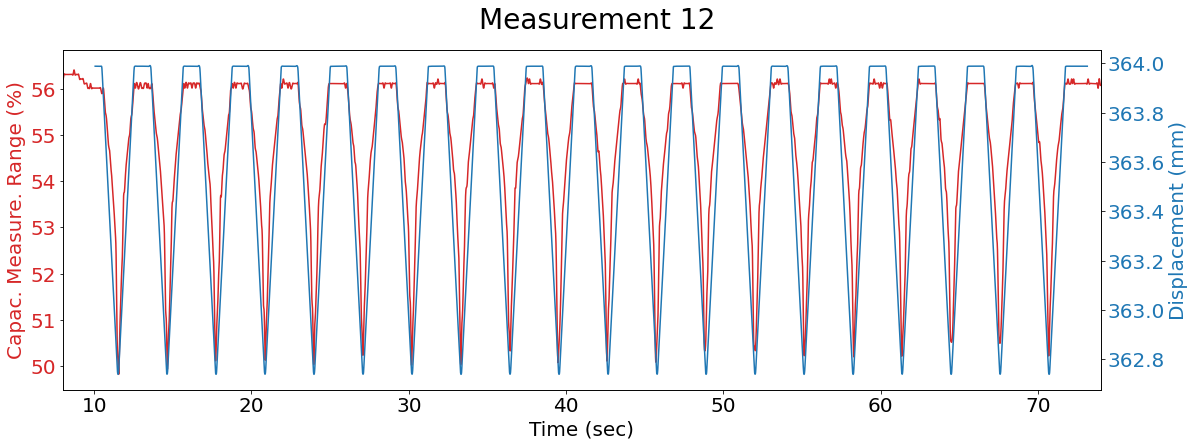

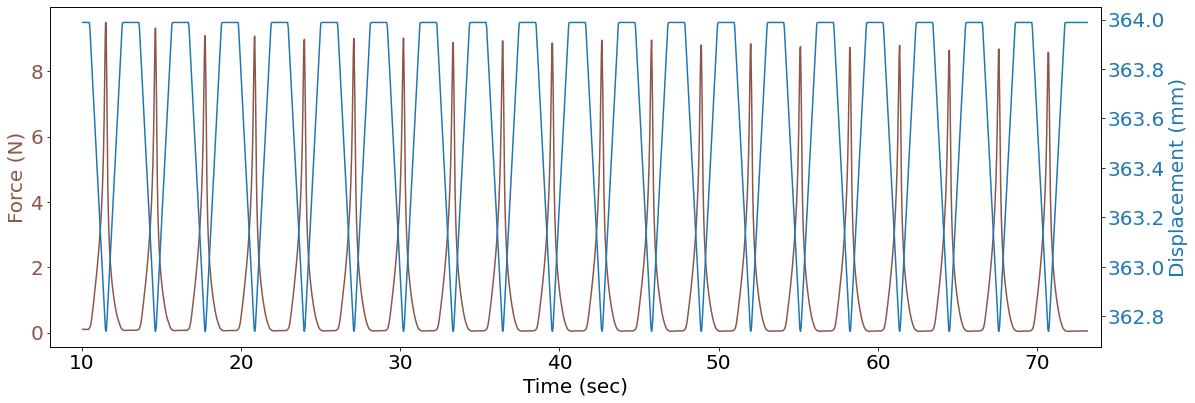

In [8]:
capa = np.genfromtxt(ospa.join(dataPath, 'Data_Fs17Hz_at15-39-11_OfficialTest_t12.csv'), delimiter=',')
t1 = np.arange(capa.shape[0])/17.2

timeFlag = [8, 74] # Begin and end time of displayed measurement

measurementNum = 12
keyStr0 = ("Measurement %d" % measurementNum)
keyStr1 = ("Measurement %d.1" % measurementNum)
keyStr2 = ("Measurement %d.2" % measurementNum)

fo = pd.read_excel(xlsData, keyStr0)
t2 = fo.loc[2:,keyStr0]
Force = fo.loc[2:,keyStr1]
Disp = fo.loc[2:,keyStr2]
    
cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,0], t1, -Disp, t2)
plt.gcf().suptitle(keyStr0, fontsize=figTitleSize, y=1.05)
plt.gca().set_xlim(timeFlag);

plotForceDispl(Force, Disp, t2, tShift)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,0], t1, timeFlag)
print("Measurement %d SNR = %.2f dB\n" % (measurementNum, signalSNR))

Automatically Shifted 8.114 sec
Measured signals span 6.007% of board measurement range
Measurement 13 SNR = 32.00 dB



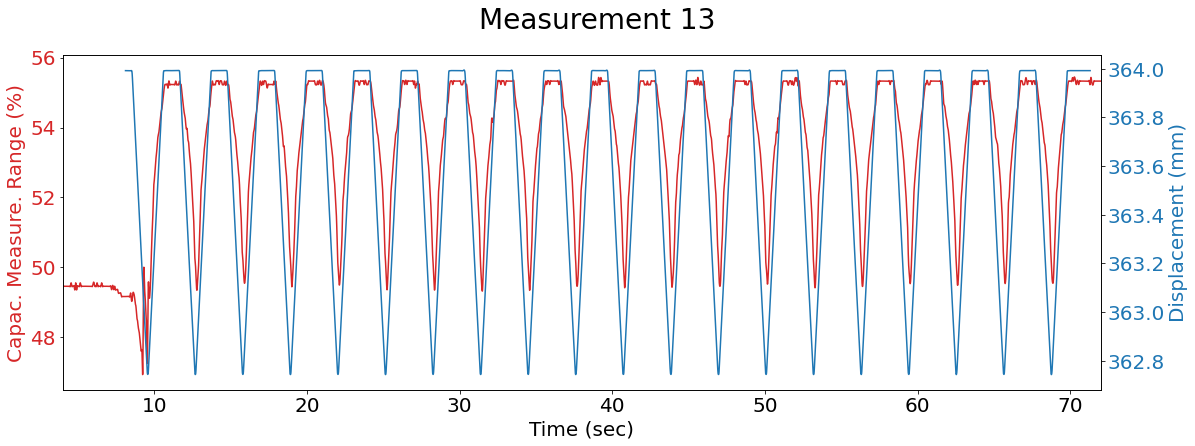

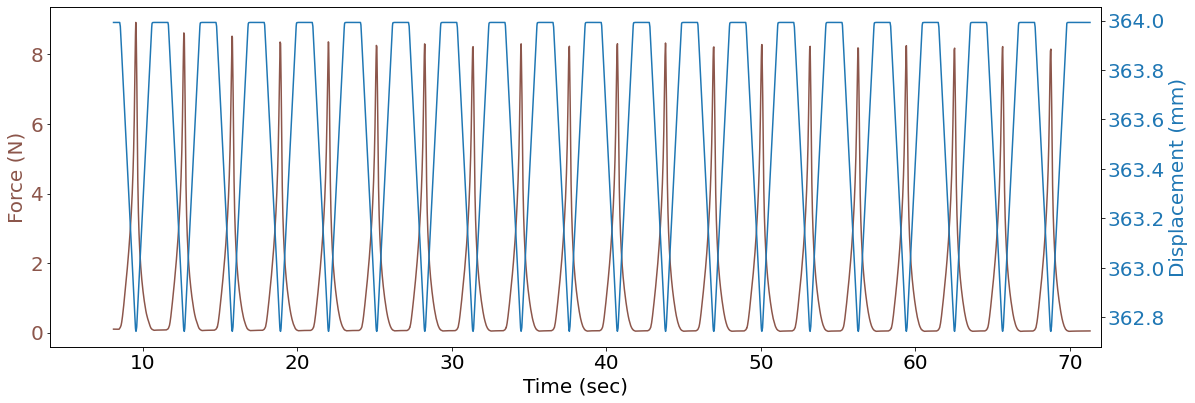

In [9]:
capa = np.genfromtxt(ospa.join(dataPath, 'Data_Fs20Hz_at15-42-22_OfficialTest_t13.csv'), delimiter=',')
t1 = np.arange(capa.shape[0])/20

timeFlag = [4, 72] # Begin and end time of displayed measurement

measurementNum = 13
keyStr0 = ("Measurement %d" % measurementNum)
keyStr1 = ("Measurement %d.1" % measurementNum)
keyStr2 = ("Measurement %d.2" % measurementNum)

fo = pd.read_excel(xlsData, keyStr0)
t2 = fo.loc[2:,keyStr0]
Force = fo.loc[2:,keyStr1]
Disp = fo.loc[2:,keyStr2]
    
cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,0], t1, -Disp, t2, manualShift = -3.2)
plt.gcf().suptitle(keyStr0, fontsize=figTitleSize, y=1.05)
plt.gca().set_xlim(timeFlag);

plotForceDispl(Force, Disp, t2, tShift)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,0], t1, timeFlag)
print("Measurement %d SNR = %.2f dB\n" % (measurementNum, signalSNR))

Automatically Shifted 7.350 sec
Measured signals span 6.083% of board measurement range
Measurement 14 SNR = 32.51 dB



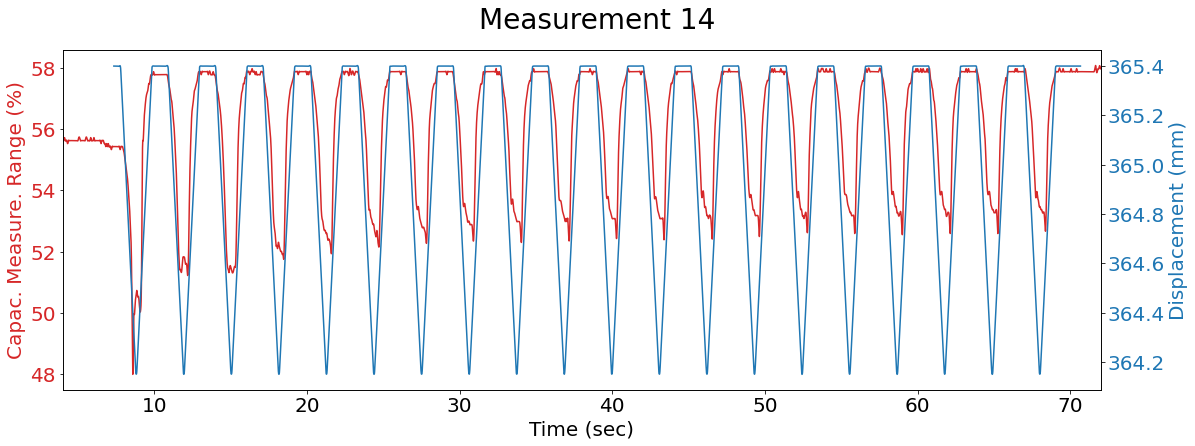

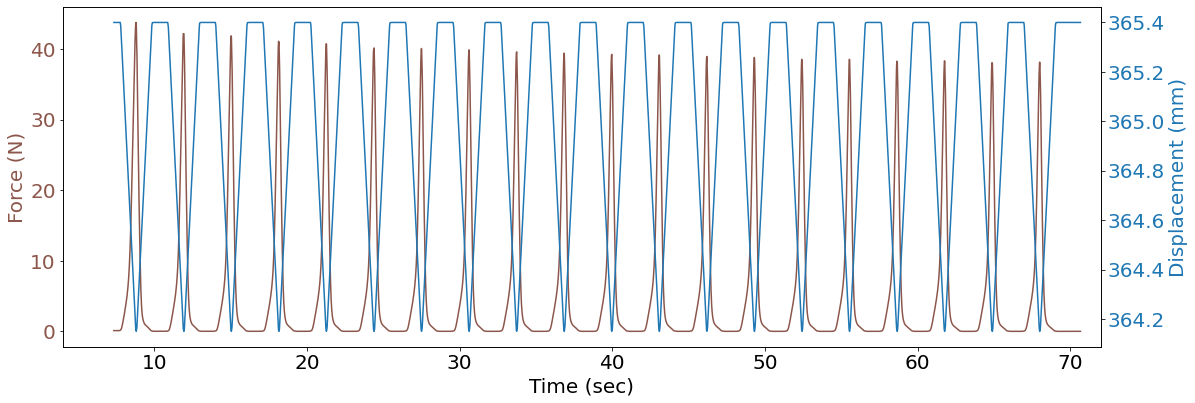

In [10]:
capa = np.genfromtxt(ospa.join(dataPath, 'Data_Fs19Hz_at15-59-18_OfficialTest_t14.csv'), delimiter=',')
t1 = np.arange(capa.shape[0])/19.2

timeFlag = [4, 72] # Begin and end time of displayed measurement

measurementNum = 14
keyStr0 = ("Measurement %d" % measurementNum)
keyStr1 = ("Measurement %d.1" % measurementNum)
keyStr2 = ("Measurement %d.2" % measurementNum)

fo = pd.read_excel(xlsData, keyStr0)
t2 = fo.loc[2:,keyStr0]
Force = fo.loc[2:,keyStr1]
Disp = fo.loc[2:,keyStr2]
    
cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,0], t1, -Disp, t2)
plt.gcf().suptitle(keyStr0, fontsize=figTitleSize, y=1.05)
plt.gca().set_xlim(timeFlag);

plotForceDispl(Force, Disp, t2, tShift)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,0], t1, timeFlag)
print("Measurement %d SNR = %.2f dB\n" % (measurementNum, signalSNR))

Automatically Shifted 10.182 sec
Measured signals span 1.075% of board measurement range
Measurement 17 Pressing Taxel SNR = 9.64 dB

Measured signals span 0.859% of board measurement range
Measurement 17 Inactive Taxel SNR = 3.15 dB



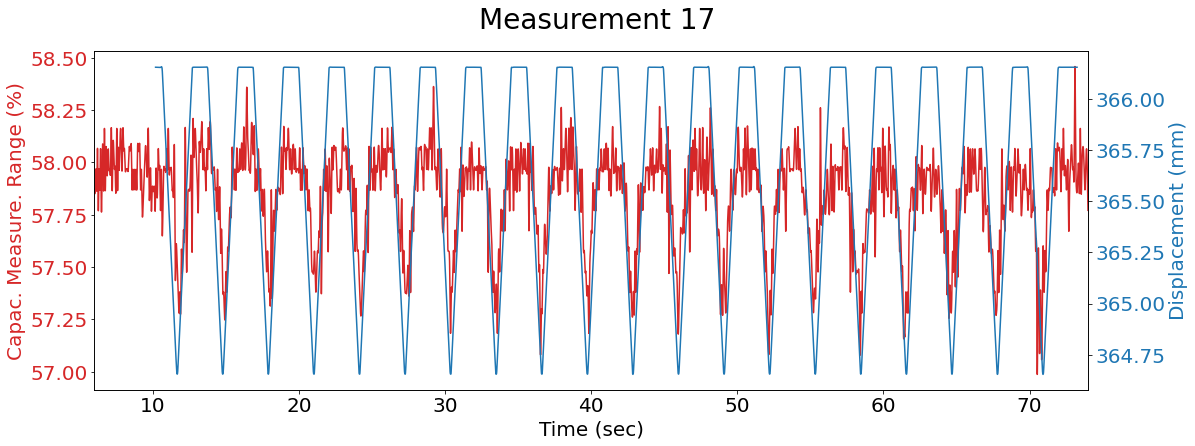

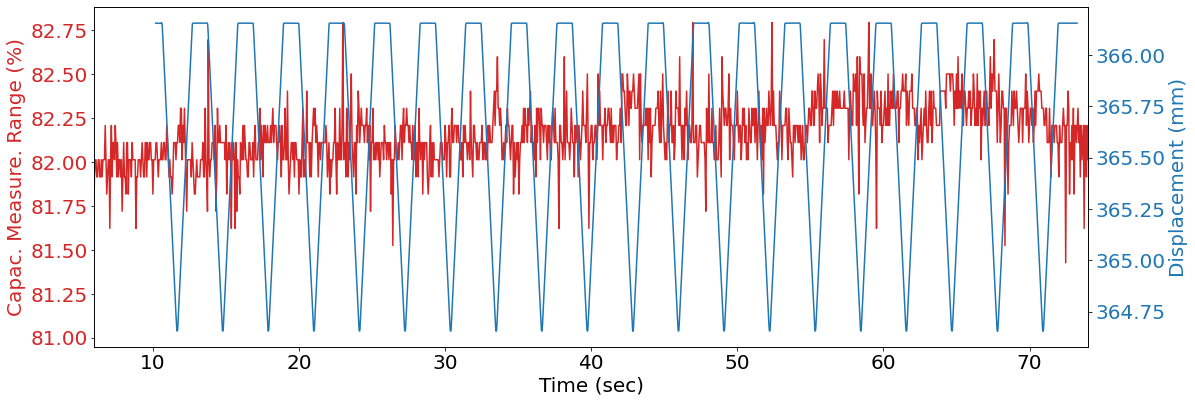

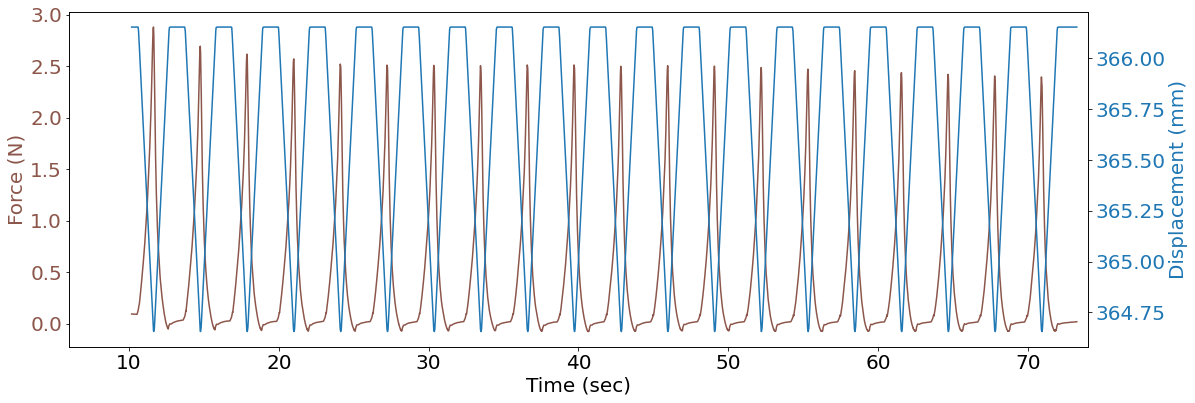

In [11]:
capa = np.genfromtxt(ospa.join(dataPath, 'Data_Fs18Hz_at16-28-29_OfficialTest_t17.csv'), delimiter=',')
t1 = np.arange(capa.shape[0])/19

timeFlag = [6, 74] # Begin and end time of displayed measurement

measurementNum = 17
keyStr0 = ("Measurement %d" % measurementNum)
keyStr1 = ("Measurement %d.1" % measurementNum)
keyStr2 = ("Measurement %d.2" % measurementNum)

fo = pd.read_excel(xlsData, keyStr0)
t2 = fo.loc[2:,keyStr0]
Force = fo.loc[2:,keyStr1]
Disp = fo.loc[2:,keyStr2]
    
cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,0], t1, -Disp, t2)
plt.gcf().suptitle(keyStr0, fontsize=figTitleSize, y=1.05)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,0], t1, timeFlag)
print("Measurement %d Pressing Taxel SNR = %.2f dB\n" % (measurementNum, signalSNR))

fig17, ax17 = plt.subplots()
ax17.set_xlabel('Time (sec)')

ax17.plot(t1, capa[:,1]/sensorRange * 100, color='tab:red')
ax17.set_ylabel('Capac. Measure. Range (%)', color='tab:red')
ax17.tick_params(axis='y', labelcolor='tab:red')

ax17b = ax17.twinx() 
ax17b.plot(tS2, dSm, color='tab:blue')
ax17b.set_ylabel('Displacement (mm)', color='tab:blue')
ax17b.tick_params(axis='y', labelcolor='tab:blue')
plt.gca().set_xlim(timeFlag);
fig17.tight_layout() 

plotForceDispl(Force, Disp, t2, tShift)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,1], t1, timeFlag)
print("Measurement %d Inactive Taxel SNR = %.2f dB\n" % (measurementNum, signalSNR))

Measured signals span 1.526% of board measurement range
Measurement 18 Pressing Taxel SNR = 13.17 dB

Measured signals span 0.830% of board measurement range
Measurement 18 Inactive Taxel SNR = 2.99 dB



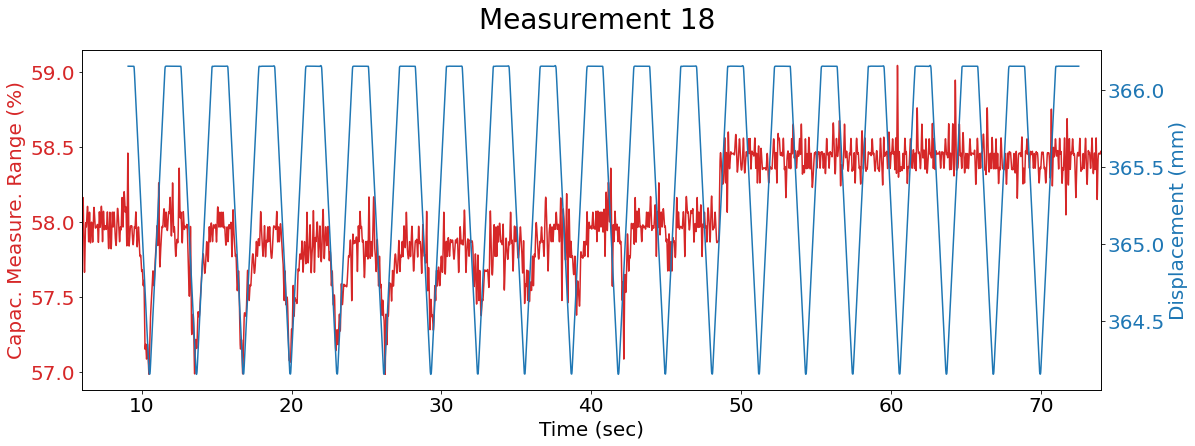

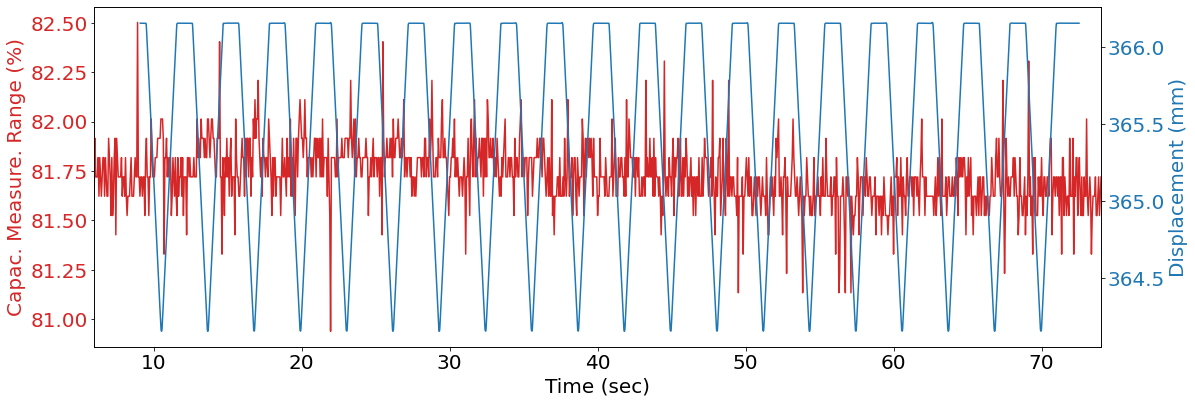

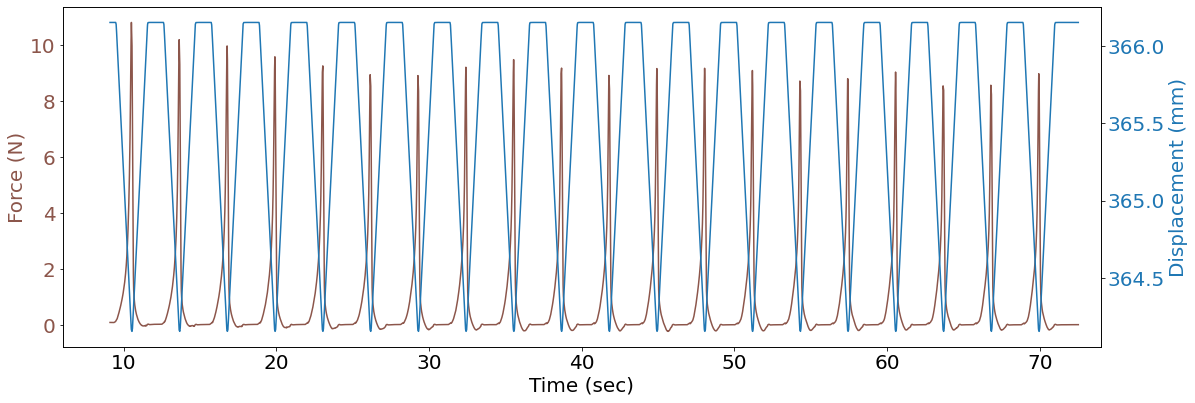

In [12]:
capa = np.genfromtxt(ospa.join(dataPath, 'Data_Fs18Hz_at16-31-05_OfficialTest_t18.csv'), delimiter=',')
t1 = np.arange(capa.shape[0])/18.4

timeFlag = [6, 74] # Begin and end time of displayed measurement

measurementNum = 18
keyStr0 = ("Measurement %d" % measurementNum)
keyStr1 = ("Measurement %d.1" % measurementNum)
keyStr2 = ("Measurement %d.2" % measurementNum)

fo = pd.read_excel(xlsData, keyStr0)
t2 = fo.loc[2:,keyStr0]
Force = fo.loc[2:,keyStr1]
Disp = fo.loc[2:,keyStr2]
    
cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,0], t1, -Disp, t2, manualShift = 9.1)
plt.gcf().suptitle(keyStr0, fontsize=figTitleSize, y=1.05)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,0], t1, timeFlag)
print("Measurement %d Pressing Taxel SNR = %.2f dB\n" % (measurementNum, signalSNR))

fig18, ax18 = plt.subplots()
ax18.set_xlabel('Time (sec)')

ax18.plot(t1, capa[:,1]/sensorRange * 100, color='tab:red')
ax18.set_ylabel('Capac. Measure. Range (%)', color='tab:red')
ax18.tick_params(axis='y', labelcolor='tab:red')

ax18b = ax18.twinx() 
ax18b.plot(tS2, dSm, color='tab:blue')
ax18b.set_ylabel('Displacement (mm)', color='tab:blue')
ax18b.tick_params(axis='y', labelcolor='tab:blue')
plt.gca().set_xlim(timeFlag);
fig18.tight_layout() 

plotForceDispl(Force, Disp, t2, tShift)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,1], t1, timeFlag)
print("Measurement %d Inactive Taxel SNR = %.2f dB\n" % (measurementNum, signalSNR))

Automatically Shifted 7.362 sec
Measured signals span 7.461% of board measurement range
Measurement 19 Pressing Taxel SNR = 26.24 dB

Measured signals span 1.026% of board measurement range
Measurement 19 Inactive Taxel SNR = 3.96 dB



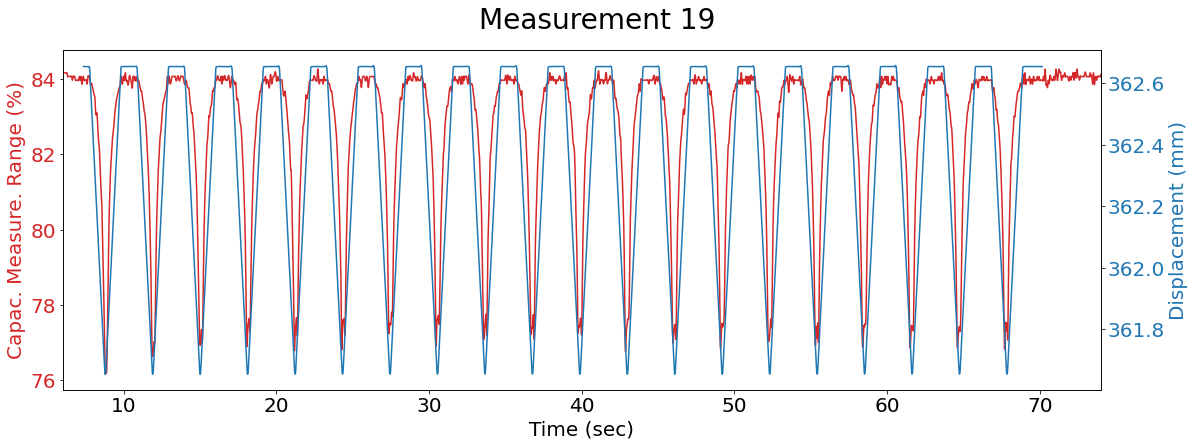

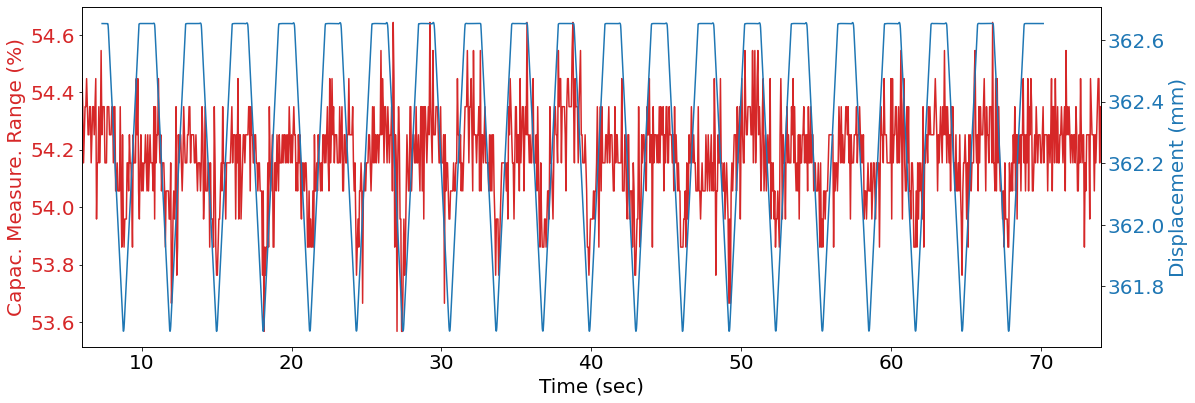

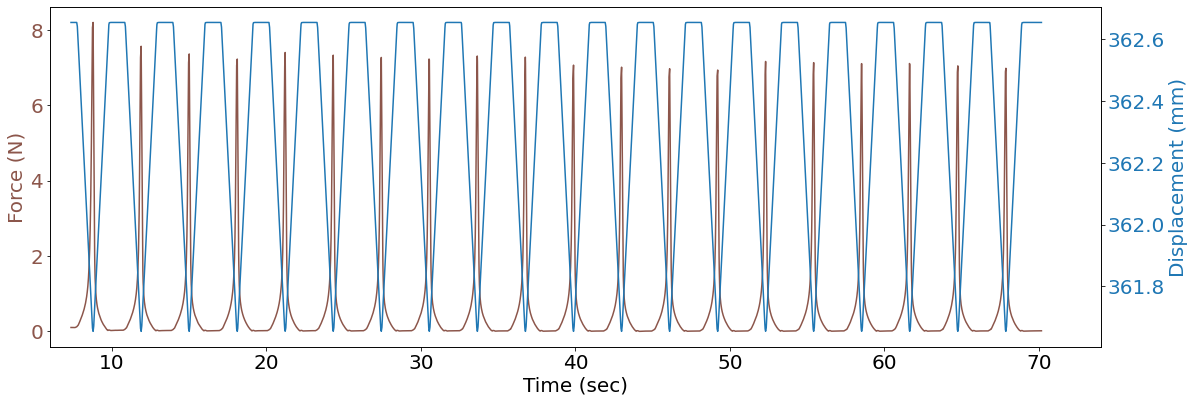

In [13]:
capa = np.genfromtxt(ospa.join(dataPath, 'Data_Fs19Hz_at16-40-23_OfficialTest_t19.csv'), delimiter=',')
t1 = np.arange(capa.shape[0])/19.6

timeFlag = [6, 74] # Begin and end time of displayed measurement

measurementNum = 19
keyStr0 = ("Measurement %d" % measurementNum)
keyStr1 = ("Measurement %d.1" % measurementNum)
keyStr2 = ("Measurement %d.2" % measurementNum)

fo = pd.read_excel(xlsData, keyStr0)
t2 = fo.loc[2:,keyStr0]
Force = fo.loc[2:,keyStr1]
Disp = fo.loc[2:,keyStr2]
    
cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,1], t1, -Disp, t2)
plt.gcf().suptitle(keyStr0, fontsize=figTitleSize, y=1.05)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,1], t1, timeFlag)
print("Measurement %d Pressing Taxel SNR = %.2f dB\n" % (measurementNum, signalSNR))

figTemp, axTemp = plt.subplots()
axTemp.set_xlabel('Time (sec)')

axTemp.plot(t1, capa[:,0]/sensorRange * 100, color='tab:red')
axTemp.set_ylabel('Capac. Measure. Range (%)', color='tab:red')
axTemp.tick_params(axis='y', labelcolor='tab:red')

axTempb = axTemp.twinx() 
axTempb.plot(tS2, dSm, color='tab:blue')
axTempb.set_ylabel('Displacement (mm)', color='tab:blue')
axTempb.tick_params(axis='y', labelcolor='tab:blue')
plt.gca().set_xlim(timeFlag);
figTemp.tight_layout() 

plotForceDispl(Force, Disp, t2, tShift)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,0], t1, timeFlag)
print("Measurement %d Inactive Taxel SNR = %.2f dB\n" % (measurementNum, signalSNR))

Automatically Shifted 9.696 sec
Measured signals span 6.690% of board measurement range
Measurement 20 Pressing Taxel SNR = 25.28 dB

Measured signals span 1.505% of board measurement range
Measurement 20 Inactive Taxel SNR = 12.25 dB



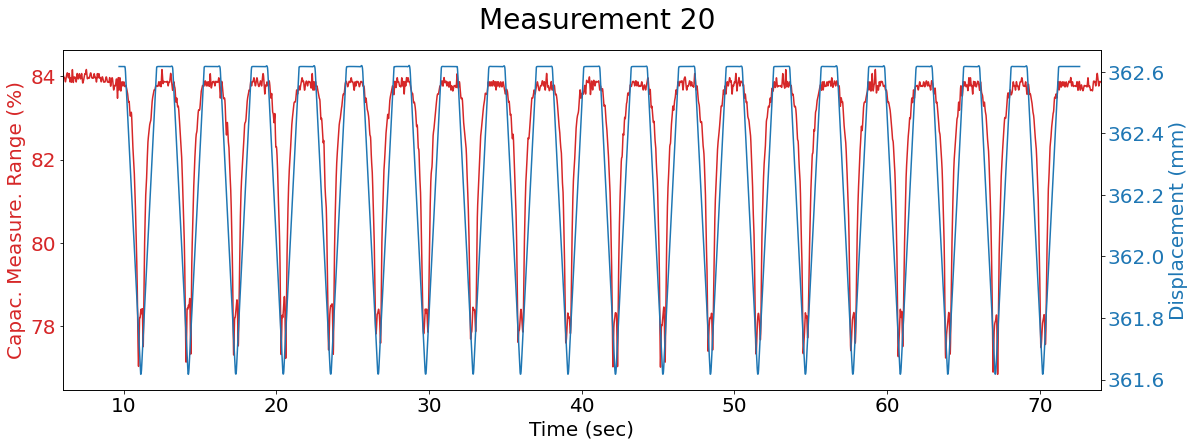

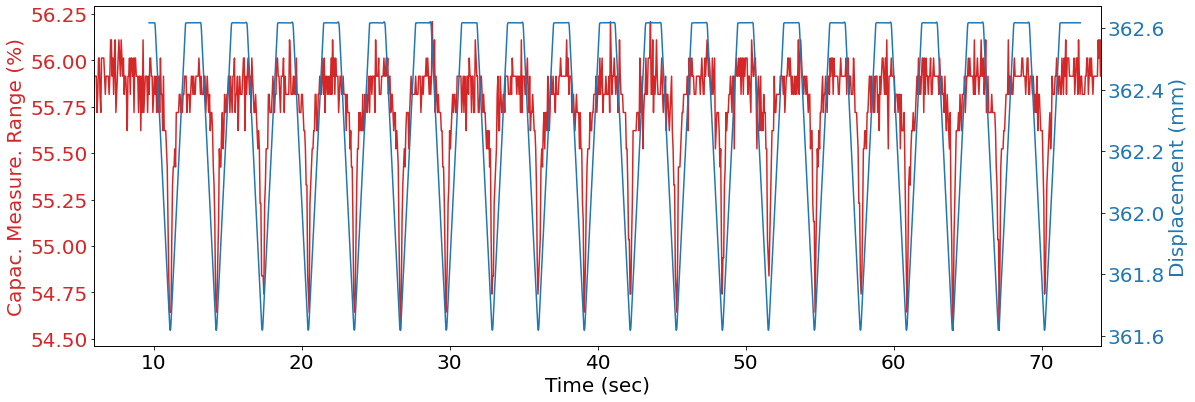

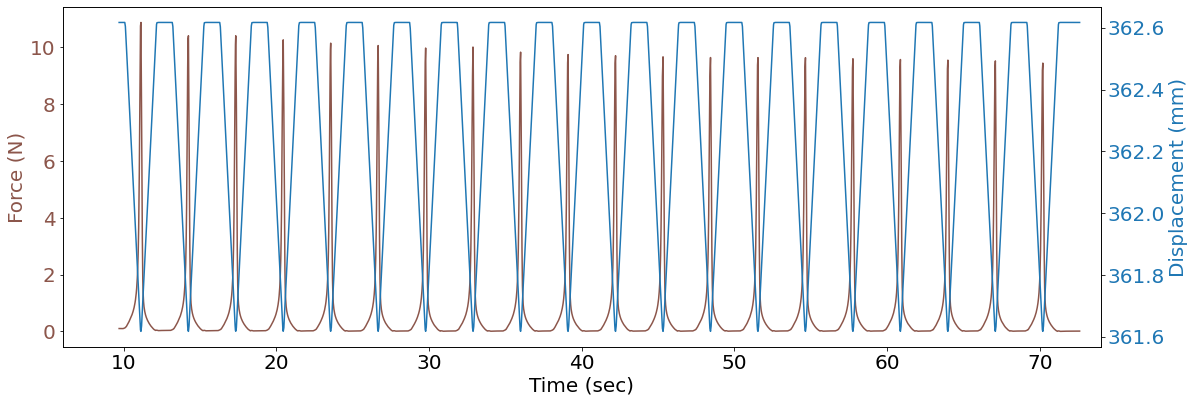

In [14]:
capa = np.genfromtxt(ospa.join(dataPath, 'Data_Fs19Hz_at16-44-46_OfficialTest_t20.csv'), delimiter=',')
t1 = np.arange(capa.shape[0])/19.6

timeFlag = [6, 74] # Begin and end time of displayed measurement

measurementNum = 20
keyStr0 = ("Measurement %d" % measurementNum)
keyStr1 = ("Measurement %d.1" % measurementNum)
keyStr2 = ("Measurement %d.2" % measurementNum)

fo = pd.read_excel(xlsData, keyStr0)
t2 = fo.loc[2:,keyStr0]
Force = fo.loc[2:,keyStr1]
Disp = fo.loc[2:,keyStr2]
    
cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,1], t1, -Disp, t2)
plt.gcf().suptitle(keyStr0, fontsize=figTitleSize, y=1.05)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,1], t1, timeFlag)
print("Measurement %d Pressing Taxel SNR = %.2f dB\n" % (measurementNum, signalSNR))

figTemp, axTemp = plt.subplots()
axTemp.set_xlabel('Time (sec)')

axTemp.plot(t1, capa[:,0]/sensorRange * 100, color='tab:red')
axTemp.set_ylabel('Capac. Measure. Range (%)', color='tab:red')
axTemp.tick_params(axis='y', labelcolor='tab:red')

axTempb = axTemp.twinx() 
axTempb.plot(tS2, dSm, color='tab:blue')
axTempb.set_ylabel('Displacement (mm)', color='tab:blue')
axTempb.tick_params(axis='y', labelcolor='tab:blue')
plt.gca().set_xlim(timeFlag);
figTemp.tight_layout() 

plotForceDispl(Force, Disp, t2, tShift)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,0], t1, timeFlag)
print("Measurement %d Inactive Taxel SNR = %.2f dB\n" % (measurementNum, signalSNR))

Automatically Shifted 7.246 sec
Measured signals span 0.600% of board measurement range
Measurement 21 SNR = 9.81 dB

[[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]
 [18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29.]
 [30. 31. 32. 33. 34. 35.]]


Text(0, 0.5, 'Capac. Measure. Range (%)')

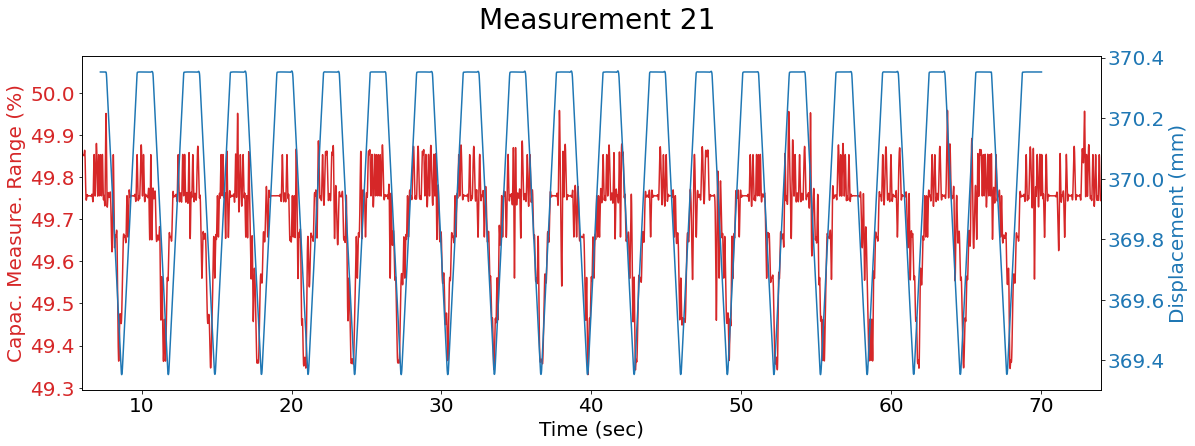

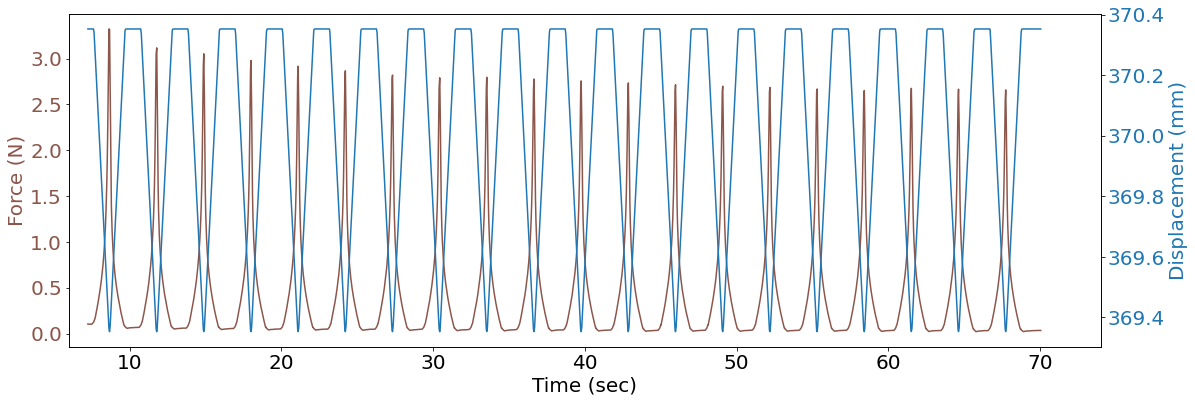

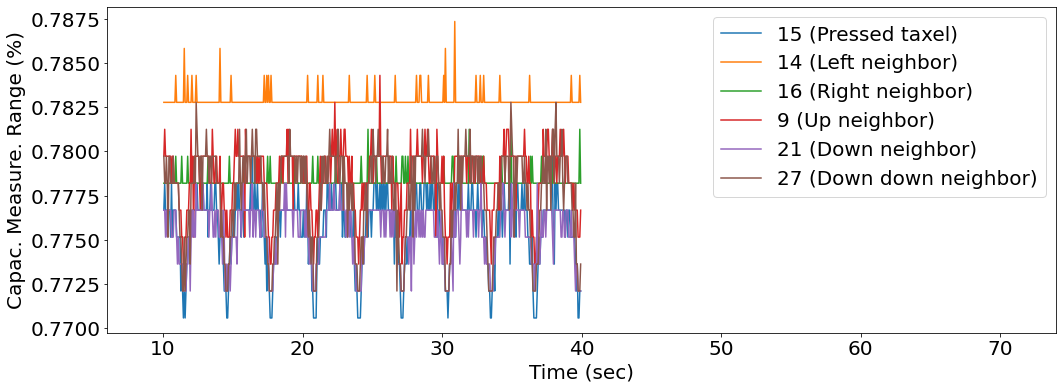

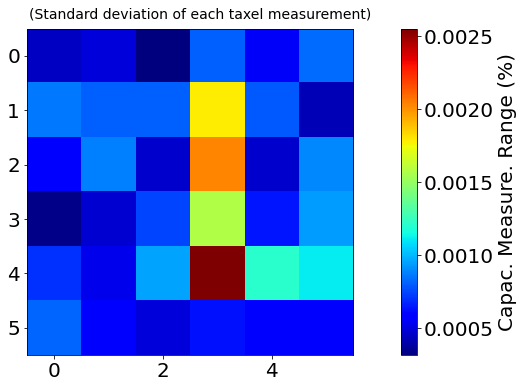

In [15]:
capa = np.genfromtxt(ospa.join(dataPath, 'Data_Fs16Hz_at17-36-52_Official36Sensor_t21.csv'), delimiter=',')
t1 = np.arange(capa.shape[0])/16.4

timeFlag = [6, 74] # Begin and end time of displayed measurement

measurementNum = 21
keyStr0 = ("Measurement %d" % measurementNum)
keyStr1 = ("Measurement %d.1" % measurementNum)
keyStr2 = ("Measurement %d.2" % measurementNum)

fo = pd.read_excel(xlsData, keyStr0)
t2 = fo.loc[2:,keyStr0]
Force = fo.loc[2:,keyStr1]
Disp = fo.loc[2:,keyStr2]
    
cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,15], t1, -Disp, t2)
plt.gcf().suptitle(keyStr0, fontsize=figTitleSize, y=1.05)
plt.gca().set_xlim(timeFlag);

plotForceDispl(Force, Disp, t2, tShift)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,15], t1, timeFlag)
print("Measurement %d SNR = %.2f dB\n" % (measurementNum, signalSNR))

# Plot Neighboring taxels 
displayInd = (t1 > 10) & (t1 < 40)
plt.subplots()
for p_i in [15, 14, 16, 9, 21, 27]:
    plt.plot(t1[displayInd], capa[displayInd,p_i]/65536*100)
axTemp = plt.gca()
axTemp.set_xlim(timeFlag);
axTemp.set_xlabel('Time (sec)')
axTemp.set_ylabel('Capac. Measure. Range (%)')
plt.legend(['15 (Pressed taxel)', '14 (Left neighbor)', '16 (Right neighbor)', '9 (Up neighbor)', 
            '21 (Down neighbor)','27 (Down down neighbor)'])

# Plot All 36 taxels
taxelInd = np.zeros(36)
taxelSTD = np.zeros(36)
for p_i in range(36):
    taxelInd[p_i] = p_i
    taxelSTD[p_i] = np.std(capa[displayInd,p_i])/65536*100
taxelInd = taxelInd.reshape((6,6)) 
taxelSTD = taxelSTD.reshape((6,6)) 
print(taxelInd)
plt.subplots()
plt.gcf().suptitle("(Standard deviation of each taxel measurement)", fontsize=14, x=0.62, y=0.93)
plt.imshow(taxelSTD, aspect='equal', cmap='jet')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Capac. Measure. Range (%)')

Measured signals span 0.786% of board measurement range
Measurement 22 SNR = 14.86 dB

[[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]
 [18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29.]
 [30. 31. 32. 33. 34. 35.]]


Text(0, 0.5, 'Capac. Measure. Range (%)')

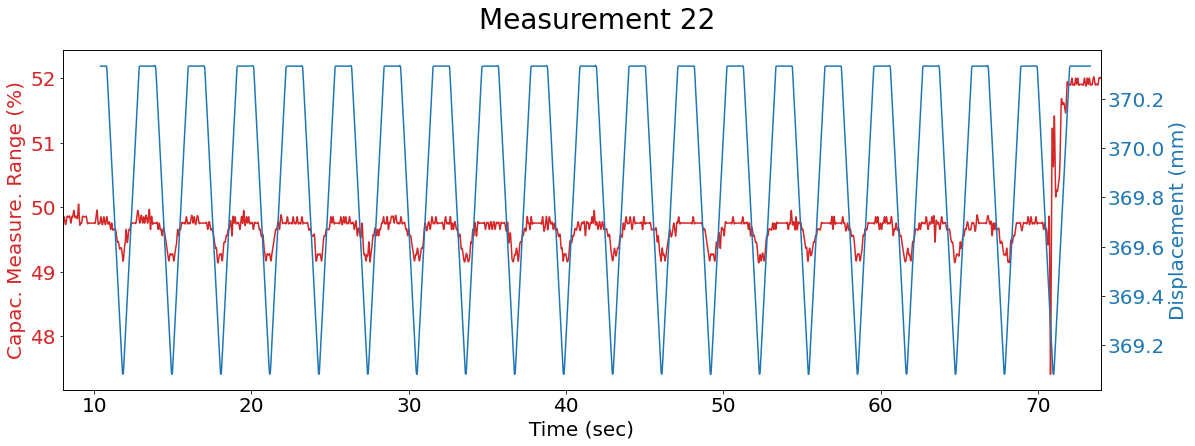

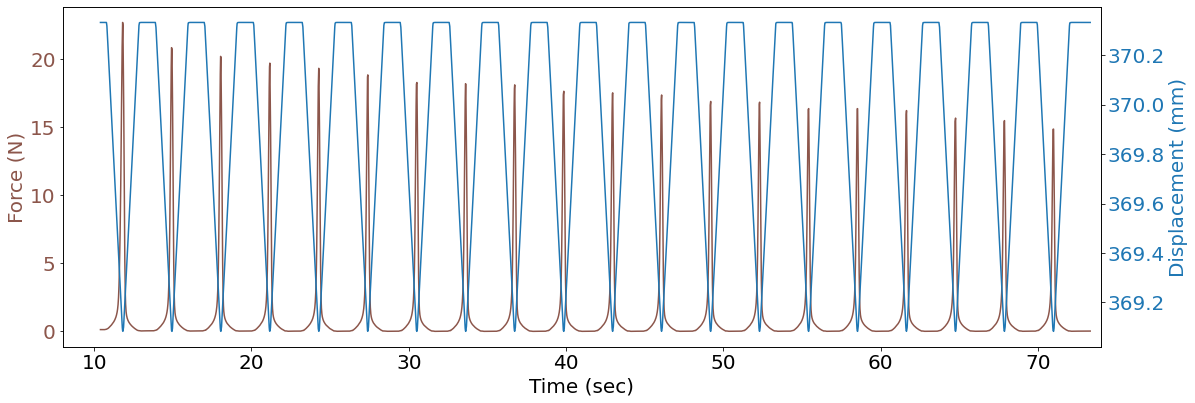

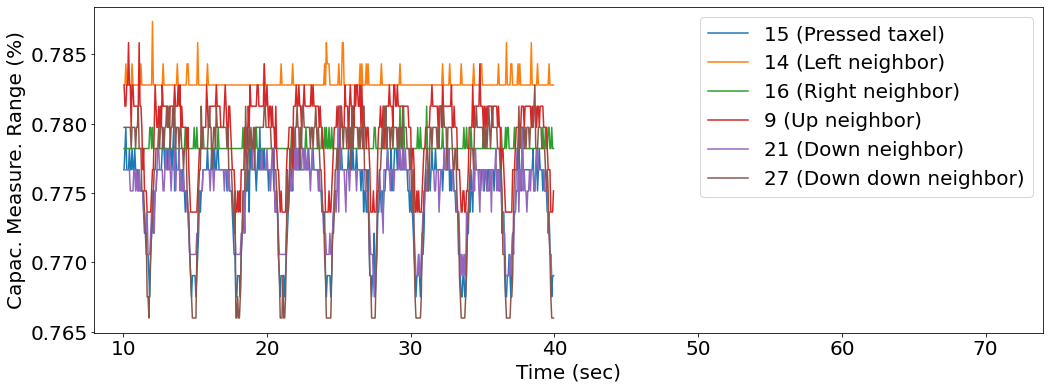

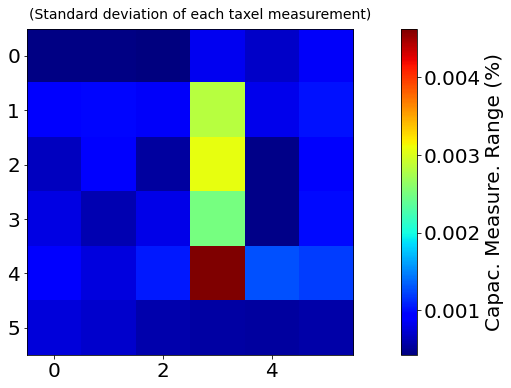

In [16]:
capa = np.genfromtxt(ospa.join(dataPath, 'Data_Fs15Hz_at17-40-21_Official36Sensor_t22.csv'), delimiter=',')
t1 = np.arange(capa.shape[0])/16.2

timeFlag = [8, 74] # Begin and end time of displayed measurement

measurementNum = 22
keyStr0 = ("Measurement %d" % measurementNum)
keyStr1 = ("Measurement %d.1" % measurementNum)
keyStr2 = ("Measurement %d.2" % measurementNum)

fo = pd.read_excel(xlsData, keyStr0)
t2 = fo.loc[2:,keyStr0]
Force = fo.loc[2:,keyStr1]
Disp = fo.loc[2:,keyStr2]
    
cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,15], t1, -Disp, t2, manualShift = 10.4)
plt.gcf().suptitle(keyStr0, fontsize=figTitleSize, y=1.05)
plt.gca().set_xlim(timeFlag);

plotForceDispl(Force, Disp, t2, tShift)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,15], t1, timeFlag, 16.2)
print("Measurement %d SNR = %.2f dB\n" % (measurementNum, signalSNR))

# Plot Neighboring taxels 
displayInd = (t1 > 10) & (t1 < 40)

plt.subplots()
for p_i in [15, 14, 16, 9, 21, 27]:
    plt.plot(t1[displayInd], capa[displayInd,p_i]/65536*100)
axTemp = plt.gca()
axTemp.set_xlim(timeFlag);
axTemp.set_xlabel('Time (sec)')
axTemp.set_ylabel('Capac. Measure. Range (%)')
plt.legend(['15 (Pressed taxel)', '14 (Left neighbor)', '16 (Right neighbor)', '9 (Up neighbor)', 
            '21 (Down neighbor)', '27 (Down down neighbor)'])

# Plot All 36 taxels
taxelInd = np.zeros(36)
taxelSTD = np.zeros(36)
for p_i in range(36):
    taxelInd[p_i] = p_i
    taxelSTD[p_i] = np.std(capa[displayInd,p_i])/65536*100
taxelInd = taxelInd.reshape((6,6)) 
taxelSTD = taxelSTD.reshape((6,6)) 
print(taxelInd)
plt.subplots()
plt.gcf().suptitle("(Standard deviation of each taxel measurement)", fontsize=14, x=0.62, y=0.93)
plt.imshow(taxelSTD, aspect='equal', cmap='jet')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Capac. Measure. Range (%)')

Automatically Shifted 10.562 sec
Measured signals span 1.885% of board measurement range
Measurement 25 SNR = 16.95 dB

[[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]
 [18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29.]
 [30. 31. 32. 33. 34. 35.]]


Text(0, 0.5, 'Capac. Measure. Range (%)')

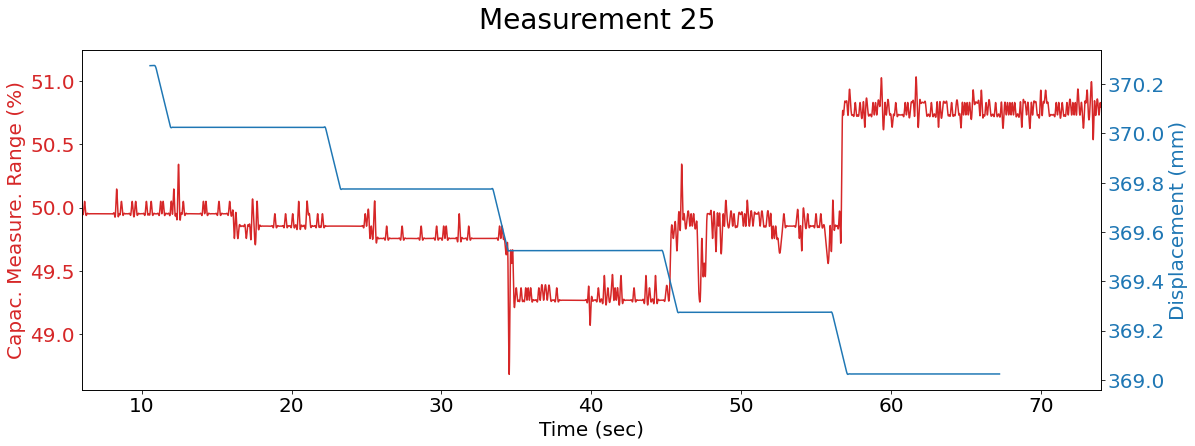

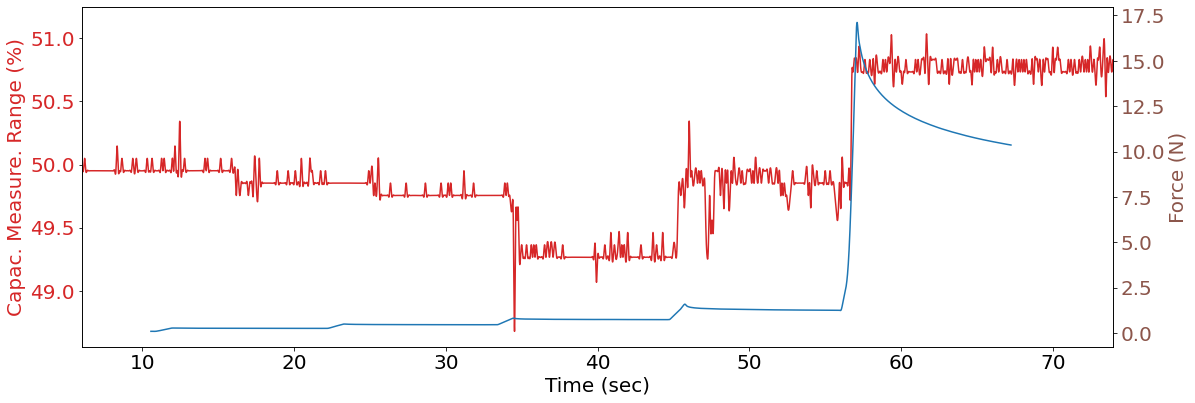

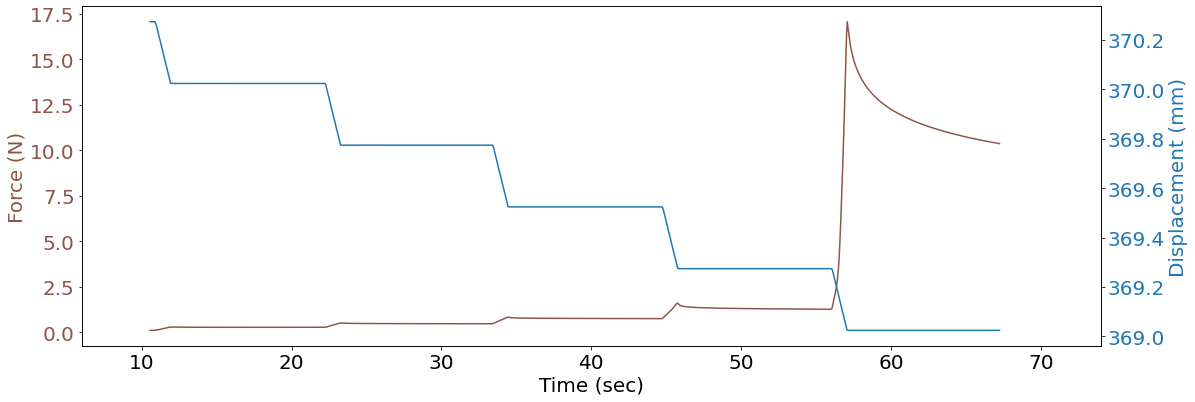

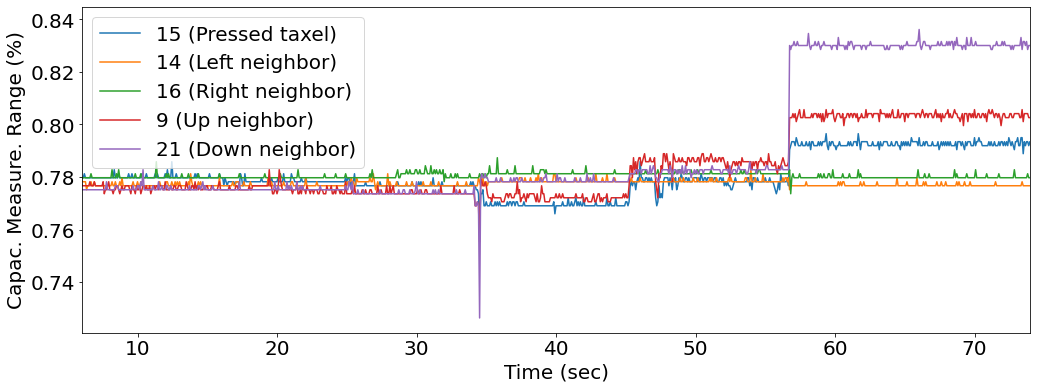

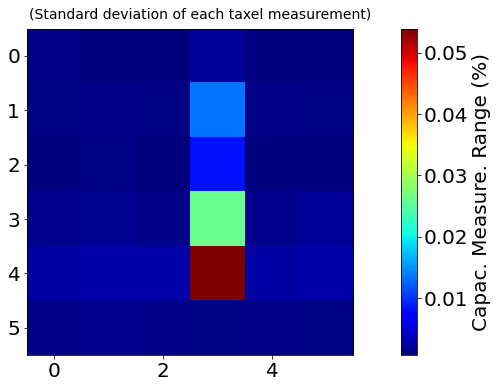

In [17]:
capa = np.genfromtxt(ospa.join(dataPath, 'Data_Fs12Hz_at17-58-40_Official36Sensor_t25.csv'), delimiter=',')
t1 = np.arange(capa.shape[0])/12.6

timeFlag = [6, 74] # Begin and end time of displayed measurement

measurementNum = 25
keyStr0 = ("Measurement %d" % measurementNum)
keyStr1 = ("Measurement %d.1" % measurementNum)
keyStr2 = ("Measurement %d.2" % measurementNum)

fo = pd.read_excel(xlsData, keyStr0)
t2 = fo.loc[2:,keyStr0]
Force = fo.loc[2:,keyStr1]
Disp = fo.loc[2:,keyStr2]
    
cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,15], t1, -Disp, t2, manualShift = 10.562)
plt.gcf().suptitle(keyStr0, fontsize=figTitleSize, y=1.05)
plt.gca().set_xlim(timeFlag);

cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,15], t1, Force, t2, manualShift = 0)
plt.gca().set_xlim(timeFlag);
plt.gca().tick_params(axis='y', labelcolor='tab:brown')
plt.gca().set_ylabel('Force (N)', color='tab:brown')

plotForceDispl(Force, Disp, t2, tShift)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,15], t1, timeFlag)
print("Measurement %d SNR = %.2f dB\n" % (measurementNum, signalSNR))

# Plot Neighboring taxels 
plt.subplots()
for p_i in [15, 14, 16, 9, 21]:
    plt.plot(t1, capa[:,p_i]/65536*100)
axTemp = plt.gca()
axTemp.set_xlim(timeFlag);
axTemp.set_xlabel('Time (sec)')
axTemp.set_ylabel('Capac. Measure. Range (%)')
plt.legend(['15 (Pressed taxel)', '14 (Left neighbor)', '16 (Right neighbor)', '9 (Up neighbor)', '21 (Down neighbor)'])

# Plot All 36 taxels
taxelInd = np.zeros(36)
taxelSTD = np.zeros(36)
for p_i in range(36):
    taxelInd[p_i] = p_i
    taxelSTD[p_i] = np.std(capa[:,p_i])/65536*100
taxelInd = taxelInd.reshape((6,6)) 
taxelSTD = taxelSTD.reshape((6,6)) 
print(taxelInd)
plt.subplots()
plt.gcf().suptitle("(Standard deviation of each taxel measurement)", fontsize=14, x=0.62, y=0.93)
plt.imshow(taxelSTD, aspect='equal', cmap='jet')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Capac. Measure. Range (%)')

Automatically Shifted 21.823 sec
Automatically Shifted 21.823 sec
Measured signals span 1.426% of board measurement range
Measurement 26 SNR = 13.52 dB

[[ 0.  1.  2.  3.  4.  5.]
 [ 6.  7.  8.  9. 10. 11.]
 [12. 13. 14. 15. 16. 17.]
 [18. 19. 20. 21. 22. 23.]
 [24. 25. 26. 27. 28. 29.]
 [30. 31. 32. 33. 34. 35.]]


Text(0, 0.5, 'Capac. Measure. Range (%)')

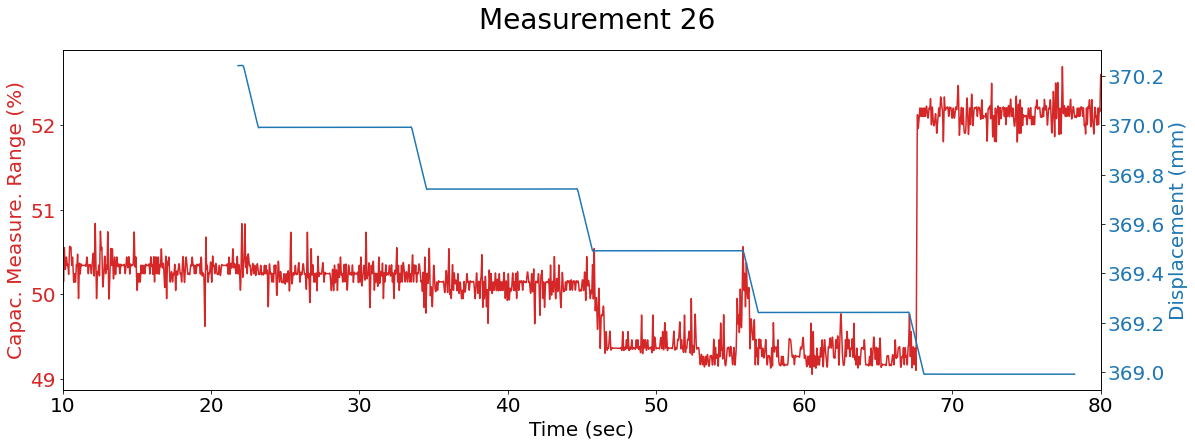

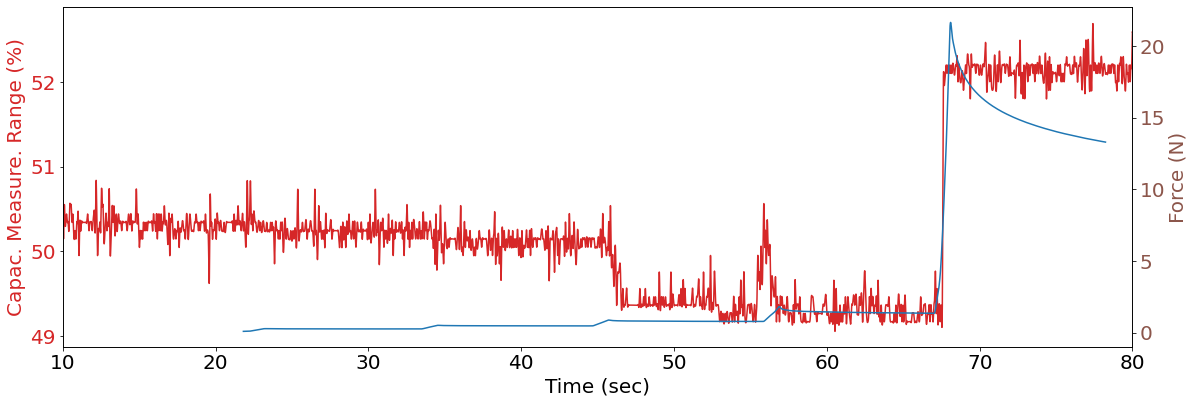

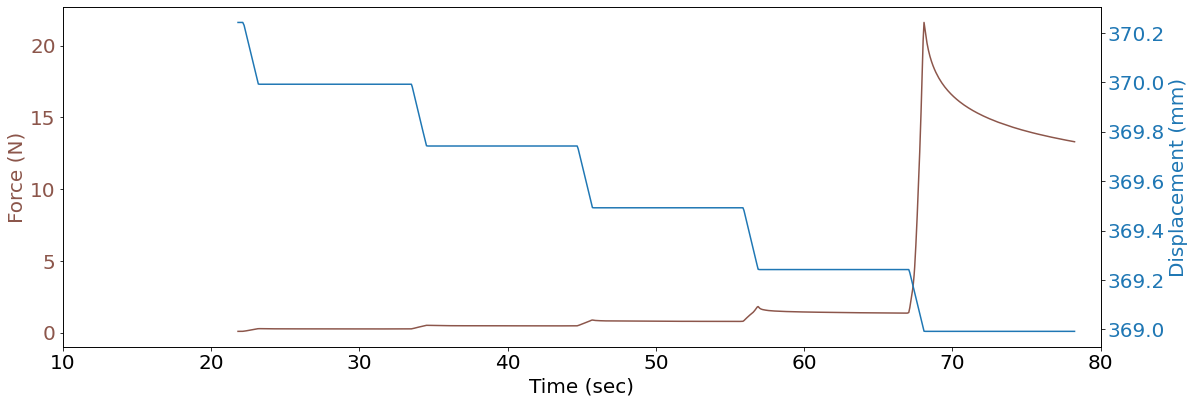

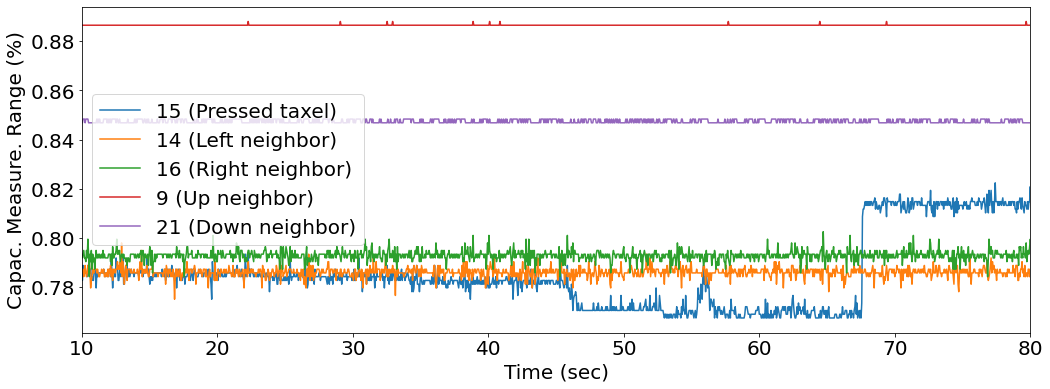

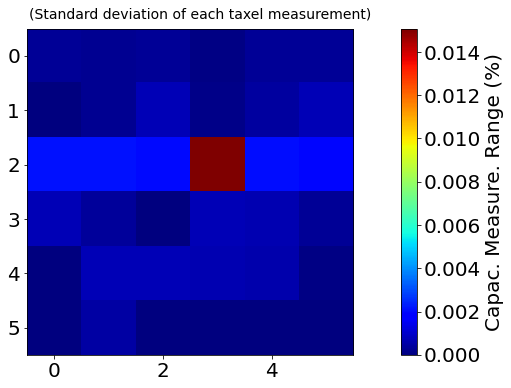

In [18]:
capa = np.genfromtxt(ospa.join(dataPath, 'Data_Fs19Hz_at18-03-29_Official1Sensor_t26.csv'), delimiter=',')
t1 = np.arange(capa.shape[0])/19.7

timeFlag = [10, 80] # Begin and end time of displayed measurement

measurementNum = 26
keyStr0 = ("Measurement %d" % measurementNum)
keyStr1 = ("Measurement %d.1" % measurementNum)
keyStr2 = ("Measurement %d.2" % measurementNum)

fo = pd.read_excel(xlsData, keyStr0)
t2 = fo.loc[2:,keyStr0]
Force = fo.loc[2:,keyStr1]
Disp = fo.loc[2:,keyStr2]
    
cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,15], t1, -Disp, t2, manualShift = 10.671)
plt.gcf().suptitle(keyStr0, fontsize=figTitleSize, y=1.05)
plt.gca().set_xlim(timeFlag);

cSm, tS1, dSm, tS2, tShift = sychronize(capa[:,15], t1, Force, t2, manualShift = 0)
plt.gca().set_xlim(timeFlag);
plt.gca().tick_params(axis='y', labelcolor='tab:brown')
plt.gca().set_ylabel('Force (N)', color='tab:brown')

plotForceDispl(Force, Disp, t2, tShift)
plt.gca().set_xlim(timeFlag);

# Compute SNR
signalSNR = computeSNR(capa[:,15], t1, timeFlag)
print("Measurement %d SNR = %.2f dB\n" % (measurementNum, signalSNR))

# Plot Neighboring taxels 
plt.subplots()
for p_i in [15, 14, 16, 9, 21]:
    plt.plot(t1, capa[:,p_i]/65536*100)
axTemp = plt.gca()
axTemp.set_xlim(timeFlag);
axTemp.set_xlabel('Time (sec)')
axTemp.set_ylabel('Capac. Measure. Range (%)')
plt.legend(['15 (Pressed taxel)', '14 (Left neighbor)', '16 (Right neighbor)', '9 (Up neighbor)', '21 (Down neighbor)'])

# Plot All 36 taxels
taxelInd = np.zeros(36)
taxelSTD = np.zeros(36)
for p_i in range(36):
    taxelInd[p_i] = p_i
    taxelSTD[p_i] = np.std(capa[:,p_i])/65536*100
taxelInd = taxelInd.reshape((6,6)) 
taxelSTD = taxelSTD.reshape((6,6)) 
print(taxelInd)
plt.subplots()
plt.gcf().suptitle("(Standard deviation of each taxel measurement)", fontsize=14, x=0.62, y=0.93)
plt.imshow(taxelSTD, aspect='equal', cmap='jet')
cbar = plt.colorbar()
cbar.ax.set_ylabel('Capac. Measure. Range (%)')